# 1. Imports and Function Definitions

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from scipy.special import expit

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def non_max_suppression(boxes, scores, iou_threshold=0.5):
    sorted_indices = np.argsort(scores)[::-1]
    keep = []
    
    while len(sorted_indices) > 0:
        current_idx = sorted_indices[0]
        keep.append(current_idx)
        
        remaining_indices = sorted_indices[1:]
        filtered_indices = []
        
        for idx in remaining_indices:
            iou = compute_iou(boxes[current_idx], boxes[idx])
            if iou <= iou_threshold:
                filtered_indices.append(idx)
        
        sorted_indices = np.array(filtered_indices)
    
    return keep

# 2. Loading a model to be the main model

In [2]:
# — load class names
cfg = yaml.safe_load(open('models\YOLO_LC\st_yolo_lc_v1_256_config.yaml'))
class_names = cfg['dataset']['class_names']

# - load model
model = tf.keras.models.load_model('models\YOLO_LC\st_yolo_lc_v1_256.h5')
print("expects:", model.input_shape, model.input.dtype)

# - view all model layers
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - output shape: {layer.output_shape}")

expects: (None, 256, 256, 3) <dtype: 'float32'>
0: input_1 - output shape: [(None, 256, 256, 3)]
1: conv2d - output shape: (None, 128, 128, 16)
2: batch_normalization - output shape: (None, 128, 128, 16)
3: activation - output shape: (None, 128, 128, 16)
4: conv2d_1 - output shape: (None, 64, 64, 32)
5: batch_normalization_1 - output shape: (None, 64, 64, 32)
6: activation_1 - output shape: (None, 64, 64, 32)
7: conv2d_2 - output shape: (None, 32, 32, 64)
8: batch_normalization_2 - output shape: (None, 32, 32, 64)
9: activation_2 - output shape: (None, 32, 32, 64)
10: conv2d_3 - output shape: (None, 16, 16, 128)
11: batch_normalization_3 - output shape: (None, 16, 16, 128)
12: activation_3 - output shape: (None, 16, 16, 128)
13: depthwise_conv2d - output shape: (None, 16, 16, 128)
14: batch_normalization_4 - output shape: (None, 16, 16, 128)
15: conv2d_4 - output shape: (None, 16, 16, 256)
16: batch_normalization_5 - output shape: (None, 16, 16, 256)
17: activation_4 - output shape: (N

# 3. Setting YOLO LC ancors

In [13]:
anchors = np.array([
  [0.57273, 0.677385],
  [1.87446, 2.06253],
  [3.33843, 5.47434],
  [7.88282, 3.52778],
  [9.77052, 9.16828],
])

# 4. Load Image

(1, 256, 256, 3) float32 0.0 1.0


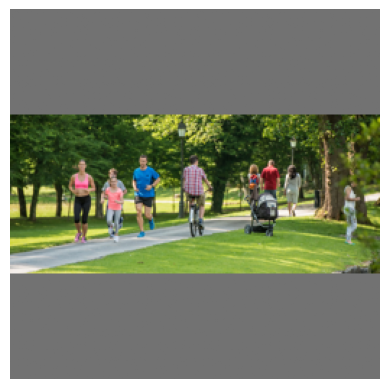

In [43]:
# Load the image
img = Image.open('testImages\YOLO\lotsOfPeople.jpg').convert('RGB')
# Resize while maintaining aspect ratio by padding
desired_size =  model.input_shape[1]
img = ImageOps.pad(img, (desired_size, desired_size), color=(114, 114, 114))

# Convert to numpy array and scale to [0, 1]
img_array = np.asarray(img, dtype=np.float32) / 255.0

# If model expects batch dimension, add it:
img_array = img_array[np.newaxis, ...] # shape: (1, 192, 192, 3)

print(img_array.shape, img_array.dtype, img_array.min(), img_array.max())
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

# 5. Perform Inference

In [44]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

# 6. Decode Inference

In [49]:
p = model.predict(img_array)
print(p[0, 0, 0, :])
batch, H, W, C = p.shape
print(p.shape, p.dtype, p.min(), p.max())
NC = 1
NA = C // (5+NC)
p = np.reshape(p, (1, H, W, NA, 5+NC))
p = np.squeeze(p, axis=0)
print(p.shape, p.dtype, p.min(), p.max())

all_boxes, all_scores = [], []
stride = model.input_shape[1] // H

conf_threshold = 0.15
print(p[0,0,0,:5])
for i in range(H):
     for j in range(W):
       for a in range(NA):
          tx,ty,tw,th,to,cls = p[i,j,a,:]
          
          px,py = expit(tx), expit(ty)
          cx = (j + px) * stride
          cy = (i + py) * stride
          
          bw = anchors[a][0] * np.exp(tw)
          bh = anchors[a][1] * np.exp(th)
          
          x1 = cx - bw/2;  y1 = cy - bh/2
          x2 = cx + bw/2;  y2 = cy + bh/2

          p_obj   = expit(to)
          p_cls   = expit(cls)
          score   = p_obj * p_cls
          
          if score > conf_threshold:
            all_boxes.append(np.stack([x1, y1, x2, y2], axis=-1))
            all_scores.append(score)
          
          
all_boxes = np.array(all_boxes)
all_scores = np.array(all_scores)

selected_indices = non_max_suppression(all_boxes, all_scores, iou_threshold=0.5)
final_boxes = all_boxes[selected_indices]
final_scores = all_scores[selected_indices]

for rank, (box, score) in enumerate(zip(final_boxes, final_scores), start=1):
    x1, y1, x2, y2 = box
    print(f"{rank}: score={score:.3f}, top_corner=({x1:.1f},{y1:.1f}), "
          f"bottom_corner=({x2:.1f}*{y2:.1f})")

[-0.22921234 -0.6388252   0.2897297  -1.5529296  -7.047909   -0.43224454
  0.33088422 -0.3859629   1.039831   -1.3698146  -7.3572464  -1.289375
  0.26533937  0.55144036 -0.41209888  0.349942   -7.9810863  -0.32882
  0.55540276 -0.12096937  0.5356855  -1.1636584  -8.032605   -0.11454265
  0.4098151  -0.47225296  0.4483441  -0.7577423  -7.725737    0.876627  ]
(1, 16, 16, 30) float32 -46.345505 7.2119813
(16, 16, 5, 6) float32 -46.345505 7.2119813
[-0.22921234 -0.6388252   0.2897297  -1.5529296  -7.047909  ]
1: score=0.581, top_corner=(229.6,120.2), bottom_corner=(243.6*152.9)
2: score=0.457, top_corner=(176.9,110.2), bottom_corner=(188.6*136.2)
3: score=0.413, top_corner=(165.3,111.3), bottom_corner=(176.4*138.2)
4: score=0.288, top_corner=(164.0,113.5), bottom_corner=(178.4*150.3)
5: score=0.214, top_corner=(173.3,112.4), bottom_corner=(189.0*150.3)
6: score=0.206, top_corner=(190.7,109.0), bottom_corner=(200.8*133.1)
7: score=0.206, top_corner=(239.6,123.5), bottom_corner=(249.6*151.4

# 7. Display inference

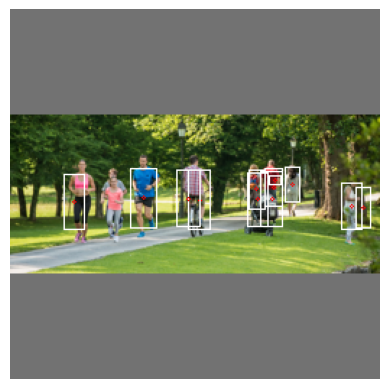

In [50]:
img_with_box = img.copy()
draw = ImageDraw.Draw(img_with_box)
circle_radius = 1

for box in final_boxes:
    cx = (box[0] + box[2]) / 2
    cy = (box[1] + box[3]) / 2
    x1, y1, x2, y2 = box
    draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="white", width=1)
    draw.ellipse(
        [(int(cx) - circle_radius, int(cy) - circle_radius), 
        (int(cx) + circle_radius, int(cy) + circle_radius)],
        outline="red", width=1
    )

plt.imshow(img_with_box)
plt.axis('off')
plt.show()